# HELIOS Seq Analysis of Hek cells
## What has been done so far...
Several DataProcessing steps were done till here with other software on the computational cluster
* fastq were trimmed and demultiplexed with cutadapt
* quality checked and further trimmed with trimmomatic
* reads were aligned with hisat2 to reference genome and reference spikeRNA, done for merged reads and not merged/paired reads separately
* count tables produced with featureCounts
* a custom python script extracts output from hisat2 for the spike RNAs and puts them in a table for further processing
* in 01_Analysis data was
  * annotated
  * filtered
  * normalized
  * spike content was compared


In [1]:
# import required modules
import os
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
from scipy.stats import ranksums
from scipy.stats import ttest_ind
from matplotlib_venn import venn3, venn3_circles

colors = sns.color_palette("tab10")
colors[8] = "gold"

#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA

#pd.set_option('display.max_columns', None)

In [2]:
adata = ad.read_h5ad("data/anndata.h5ad")
adata

AnnData object with n_obs × n_vars = 24 × 5588
    obs: 'encoding', 'pos_neg', 'treatment', 'gene_counts', 'biotinRna', 'biotin_scalingF'
    var: 'Chr', 'Start', 'End', 'Strand', 'Length', 'Ensemble_ID', 'ensembl_gene_id', 'external_gene_name', 'description', 'gene_biotype', 'entrezgene_id', 'start_position', 'end_position', 'chromosome_name', 'total_values', 'highest_sample', 'NADcap_Control', 'NADcap_FK', 'NADcap_NRH', 'NADcap_Rot', 'sums'
    uns: 'L2FC_spikes', 'enrichmentfactors_spikes', 'normalized_spike_counts', 'original_spike_table', 'spike_correlation', 'spike_counts'
    varm: 'L2FC', 'L2FC_mean_statTests', 'enrichmentfactors'
    layers: 'biotin_scaled'

## Calculating enrichment factors of the spikes

In [3]:
adata.uns["normalized_spike_counts"].head()


,biotinRna,m7G122,m7G250,m7G400,nad102A,nad200,nad351,nad36,nad501,nad60,ppp102,ppp149,ppp301,ppp51
sample,,,,,,,,,,,,,,
bc03_Control,6.480250e+07,19.575115,58.725344,19.575115,1.000895e+06,2.084045e+06,12332.322335,8.217927e+06,104080.885488,7.143461e+07,19.575115,19.575115,694.916576,332.776952
bc03_FK866,6.480249e+07,13.655994,150.215934,95.591958,6.863025e+05,8.731711e+05,4861.533867,2.933758e+06,29722.270961,6.233031e+07,13.655994,13.655994,95.591958,27.311988
bc03_NRH,6.480250e+07,22.409301,78.432555,22.409301,8.441136e+05,1.549390e+06,2845.981265,4.598176e+06,51082.002319,1.164049e+08,22.409301,22.409301,112.046507,56.023253
bc03_Rotenone,6.482081e+07,18331.676945,18331.676945,18331.676945,5.132870e+05,6.232770e+05,18331.676945,3.171380e+06,36663.353890,4.299695e+07,18331.676945,18331.676945,18331.676945,18331.676945
bc04_Control,6.480251e+07,33.261216,33.261216,33.261216,5.371686e+03,1.579908e+03,33.261216,8.230488e+04,49.891824,7.984355e+04,33.261216,33.261216,33.261216,33.261216


In [4]:
# make a mapping dictionary for assignment of positive/negative
compare = {"3": "4", "5": "6", "7": "8"}
mapping_list = []
for name in adata.obs_names:    
    i = name[3]    
    if int(i) % 2 != 0:
        o = compare[i]
        partner = name.replace(str(i), str(o))  
        new_list = [name, partner]
        mapping_list.append(new_list)

# bring it even further by assigning names
Names = ["Control1", "FK1", "NRH1", "Rot1", "Control2", "FK2", "NRH2", "Rot2", "Control3", "FK3", "NRH3", "Rot3",]
sampleMapping = list(zip(Names, mapping_list))
sampleMapping

[('Control1', ['bc03_Control', 'bc04_Control']),
 ('FK1', ['bc03_FK866', 'bc04_FK866']),
 ('NRH1', ['bc03_NRH', 'bc04_NRH']),
 ('Rot1', ['bc03_Rotenone', 'bc04_Rotenone']),
 ('Control2', ['bc05_Control', 'bc06_Control']),
 ('FK2', ['bc05_FK866', 'bc06_FK866']),
 ('NRH2', ['bc05_NRH', 'bc06_NRH']),
 ('Rot2', ['bc05_Rotenone', 'bc06_Rotenone']),
 ('Control3', ['bc07_Control', 'bc08_Control']),
 ('FK3', ['bc07_FK866', 'bc08_FK866']),
 ('NRH3', ['bc07_NRH', 'bc08_NRH']),
 ('Rot3', ['bc07_Rotenone', 'bc08_Rotenone'])]

In [5]:
enrichment_factors_spikes = {}

get_spike_array = lambda x: np.array(adata.uns["normalized_spike_counts"].loc[x,:]).flatten()

for item in sampleMapping:
    enrichment_factors_spikes[item[0]] = get_spike_array(item[1][0]) / get_spike_array(item[1][1])

adata.uns["enrichmentfactors_spikes"] = pd.DataFrame(
    enrichment_factors_spikes, 
    index = adata.uns["normalized_spike_counts"].columns)\
        .sort_index(axis=1)
adata.uns["enrichmentfactors_spikes"].index.name = "Feature"
adata.uns["enrichmentfactors_spikes"].head()

,Control1,Control2,Control3,FK1,FK2,FK3,NRH1,NRH2,NRH3,Rot1,Rot2,Rot3
Feature,,,,,,,,,,,,
biotinRna,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999914,1.000000,1.000000
m7G122,0.588527,0.992651,0.563121,0.637238,0.871264,0.526999,0.539547,1.258506,0.689174,0.767751,0.997233,0.445848
m7G250,1.765580,0.992651,0.563121,1.274475,4.356318,0.526999,1.888415,7.551038,0.689174,0.767751,0.997233,1.337545
m7G400,0.588527,0.992651,0.563121,0.743444,2.613791,5.269992,0.539547,3.775519,2.756694,0.767751,0.997233,4.012636
nad102A,186.327928,13181.532666,249.528263,1255.895449,40201.411482,306.665922,829.537416,8055.856852,822.164424,2.687129,10514.576098,454.859331


## Calculating Enrichmentfactors for the endogenous genes

In [6]:
get_gene_array = lambda x: np.array(adata.layers["biotin_scaled"].loc[x,:]).flatten()

In [7]:
adata.uns["normalized_spike_counts"].shape
adata.layers["biotin_scaled"].shape

(24, 5588)

In [8]:
enrichment_factors_genes = {}

# central datamatrix is numpy array but function relies on dataframe indexing, so i create a temporary frame
# to be abele to conveniently reuse the function

scaled_reads = pd.DataFrame(adata.layers["biotin_scaled"], index = adata.obs_names)

get_gene_array = lambda x: np.array(scaled_reads.loc[x,:]).flatten()

for item in sampleMapping:
    enrichment_factors_genes[item[0]] = get_gene_array(item[1][0]) / get_gene_array(item[1][1])

adata.varm["enrichmentfactors"] = pd.DataFrame(
    enrichment_factors_genes, 
    index = adata.var_names)\
        .sort_index(axis=1)

adata.varm["enrichmentfactors"]

,Control1,Control2,Control3,FK1,FK2,FK3,NRH1,NRH2,NRH3,Rot1,Rot2,Rot3
Feature,,,,,,,,,,,,
ENSG00000248527.1,0.588527,20.845665,2.252483,0.637238,0.871264,0.526999,7.014115,1.258506,2.756694,2.303253,0.997233,0.445848
ENSG00000291215.1,0.588527,2.977952,0.563121,11.470278,11.326427,8.431987,0.539547,1.258506,0.689174,0.767751,0.997233,0.445848
ENSG00000223764.2,0.588527,0.992651,9.573053,0.637238,0.871264,0.526999,0.539547,1.258506,0.689174,0.767751,0.997233,0.445848
ENSG00000187608.10,0.588527,0.992651,0.563121,0.637238,0.871264,0.526999,0.539547,1.258506,0.689174,8.445262,0.997233,0.445848
ENSG00000078808.20,0.588527,0.992651,0.563121,0.637238,6.098846,21.606966,0.539547,1.258506,0.689174,0.767751,0.997233,0.445848
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000291389.1,0.588527,0.992651,0.563121,0.637238,2.613791,0.526999,0.539547,3.775519,4.824215,0.767751,0.997233,1.783394
ENSG00000291396.1,0.588527,0.992651,6.194328,0.637238,0.871264,0.526999,0.539547,1.258506,0.689174,0.767751,1.994466,0.445848
ENSG00000275748.4,1.177053,0.992651,0.563121,0.637238,0.871264,6.850989,0.539547,1.258506,0.689174,0.767751,0.997233,0.445848


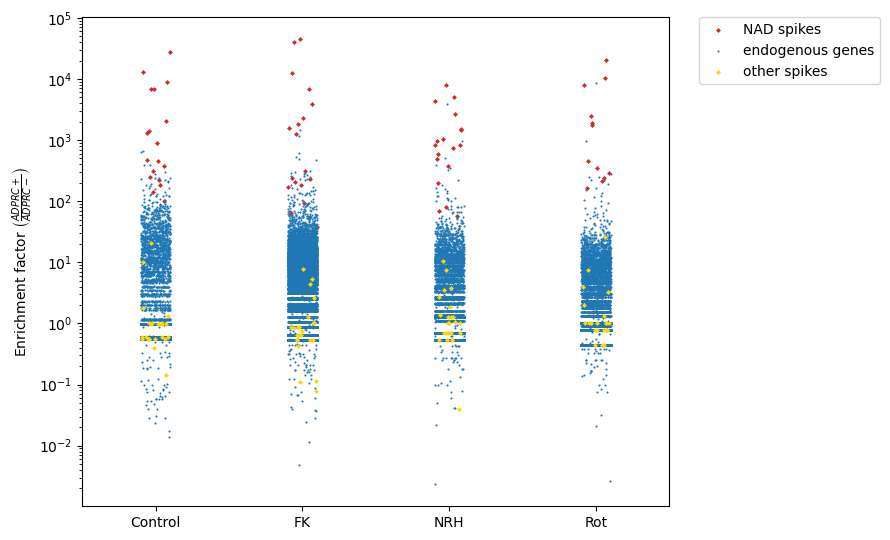

In [9]:
# plotting

df1 = adata.varm["enrichmentfactors"].reset_index()\
    .melt(id_vars = "Feature")
df1["var"] = [char[:-1] for char in df1["variable"]]

df2 = adata.uns["enrichmentfactors_spikes"].reset_index()\
    .melt(id_vars = "Feature")
df2["var"] = [char[:-1] for char in df2["variable"]]
NAD_spikes = ['nad102A', 'nad200',
       'nad351', 'nad36', 'nad501', 'nad60']
df_NADspike = df2[df2["Feature"].isin(NAD_spikes)]
df_nonNADspike = df2[~df2["Feature"].isin(NAD_spikes)]

plt.rcParams["figure.figsize"] = [9, 5.5]
plt.rcParams["figure.autolayout"] = True

ax = sns.stripplot(data = df_NADspike, y = "value", x= "var", s = 2.5, color = colors[3], label = "NAD spikes", marker = "D")
ax = sns.stripplot(data = df1, y = "value", x= "var", s = 1.5, label = "endogenous genes", color = colors[0])
ax = sns.stripplot(data = df_nonNADspike, y = "value", x= "var", s = 2.5, marker = "D",color = colors[8], label = "other spikes")
ax.set(ylabel = r'Enrichment factor $\left(\frac{ADPRC + }{ADPRC - }\right)$', xlabel="")
plt.gca().set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
plt.legend([handles[0],handles[4], handles[8]], [labels[0],labels[4], labels[8]], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

plt.savefig("figures/enrichmentfactors.png", dpi=300, pad_inches=0)

plt.show()

## Calculating L2FC changes
Here anstead of enrichment factors logfoldchanges are calculated. I hope this helps clarifying how to determine NAD capped RNA and not capped.

In [10]:
# function to get the corresponing arrary from the anndata datastructure
get_values = lambda x: np.array(adata[adata.obs.index == x,:].layers["biotin_scaled"].flatten())

# function to calculate the logfoldchanges of two arrays with same shape
l2fc = lambda x,y: np.log2(x) - np.log2(y)


In [11]:
l2FC_genes = {}

for item in sampleMapping:
    l2FC_genes[item[0]] = l2fc(get_values(item[1][0]), get_values(item[1][1]))

adata.varm["L2FC"] = pd.DataFrame(
    l2FC_genes, 
    index = adata.var_names)\
        .sort_index(axis=1)

adata.varm["L2FC"]

,Control1,Control2,Control3,FK1,FK2,FK3,NRH1,NRH2,NRH3,Rot1,Rot2,Rot3
Feature,,,,,,,,,,,,
ENSG00000248527.1,-0.76482,4.381675,1.171516,-0.650097,-0.198819,-0.924127,2.810261,0.331713,1.462939,1.203673,-0.003997,-1.165375
ENSG00000291215.1,-0.76482,1.574321,-0.828484,3.519828,3.501621,3.075873,-0.890179,0.331713,-0.537061,-0.381289,-0.003997,-1.165375
ENSG00000223764.2,-0.76482,-0.010642,3.258979,-0.650097,-0.198819,-0.924127,-0.890179,0.331713,-0.537061,-0.381289,-0.003997,-1.165375
ENSG00000187608.10,-0.76482,-0.010642,-0.828484,-0.650097,-0.198819,-0.924127,-0.890179,0.331713,-0.537061,3.078142,-0.003997,-1.165375
ENSG00000078808.20,-0.76482,-0.010642,-0.828484,-0.650097,2.608536,4.433425,-0.890179,0.331713,-0.537061,-0.381289,-0.003997,-1.165375
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000291389.1,-0.76482,-0.010642,-0.828484,-0.650097,1.386144,-0.924127,-0.890179,1.916675,2.270294,-0.381289,-0.003997,0.834625
ENSG00000291396.1,-0.76482,-0.010642,2.630948,-0.650097,-0.198819,-0.924127,-0.890179,0.331713,-0.537061,-0.381289,0.996003,-1.165375
ENSG00000275748.4,0.23518,-0.010642,-0.828484,-0.650097,-0.198819,2.776312,-0.890179,0.331713,-0.537061,-0.381289,-0.003997,-1.165375


In [12]:
# build the l2fc for the spikes
get_spike_array = lambda x: np.array(adata.uns["normalized_spike_counts"].loc[x,:]).flatten()

l2FC_spikes = {}

for item in sampleMapping:
    l2FC_spikes[item[0]] = l2fc(get_spike_array(item[1][0]), get_spike_array(item[1][1]))

adata.uns["L2FC_spikes"] = pd.DataFrame(
    l2FC_spikes,
    index = adata.uns["normalized_spike_counts"].columns)\
        .sort_index(axis=1)

adata.uns["L2FC_spikes"]

,Control1,Control2,Control3,FK1,FK2,FK3,NRH1,NRH2,NRH3,Rot1,Rot2,Rot3
Feature,,,,,,,,,,,,
biotinRna,-3.046930e-07,-3.476611e-09,-5.590252e-07,-1.730720e-07,-5.082481e-08,-3.136626e-07,-4.257617e-07,1.548920e-07,-3.979984e-07,-0.000123,-9.610694e-10,-3.046187e-07
m7G122,-7.648201e-01,-1.064196e-02,-8.284838e-01,-6.500966e-01,-1.988187e-01,-9.241274e-01,-8.901787e-01,3.317126e-01,-5.370606e-01,-0.381289,-3.997380e-03,-1.165375e+00
m7G250,8.201424e-01,-1.064196e-02,-8.284838e-01,3.499034e-01,2.123109e+00,-9.241274e-01,9.171762e-01,2.916675e+00,-5.370606e-01,-0.381289,-3.997380e-03,4.195880e-01
m7G400,-7.648201e-01,-1.064196e-02,-8.284838e-01,-4.277042e-01,1.386144e+00,2.397801e+00,-8.901787e-01,1.916675e+00,1.462939e+00,-0.381289,-3.997380e-03,2.004550e+00
nad102A,7.541700e+00,1.368623e+01,7.963059e+00,1.029450e+01,1.529496e+01,8.260524e+00,9.696163e+00,1.297582e+01,9.683283e+00,1.426065,1.336010e+01,8.829277e+00
nad200,1.036533e+01,1.274324e+01,7.808116e+00,1.272938e+01,1.189790e+01,7.532121e+00,9.232868e+00,1.053292e+01,9.548783e+00,1.706173,1.294533e+01,7.740614e+00
nad351,8.534388e+00,8.845784e+00,7.137301e+00,7.825637e+00,7.880666e+00,5.215424e+00,6.098506e+00,6.331713e+00,5.846644e+00,-0.381289,8.438946e+00,7.879020e+00
nad36,6.641653e+00,1.311568e+01,8.265438e+00,1.118012e+01,1.084866e+01,7.694662e+00,8.532424e+00,1.228972e+01,7.640638e+00,1.409483,1.127931e+01,7.371847e+00
nad501,1.102661e+01,1.273388e+01,8.870872e+00,6.011433e+00,6.563009e+00,7.407909e+00,8.942395e+00,9.901885e+00,1.004884e+01,0.618711,1.079812e+01,8.172990e+00


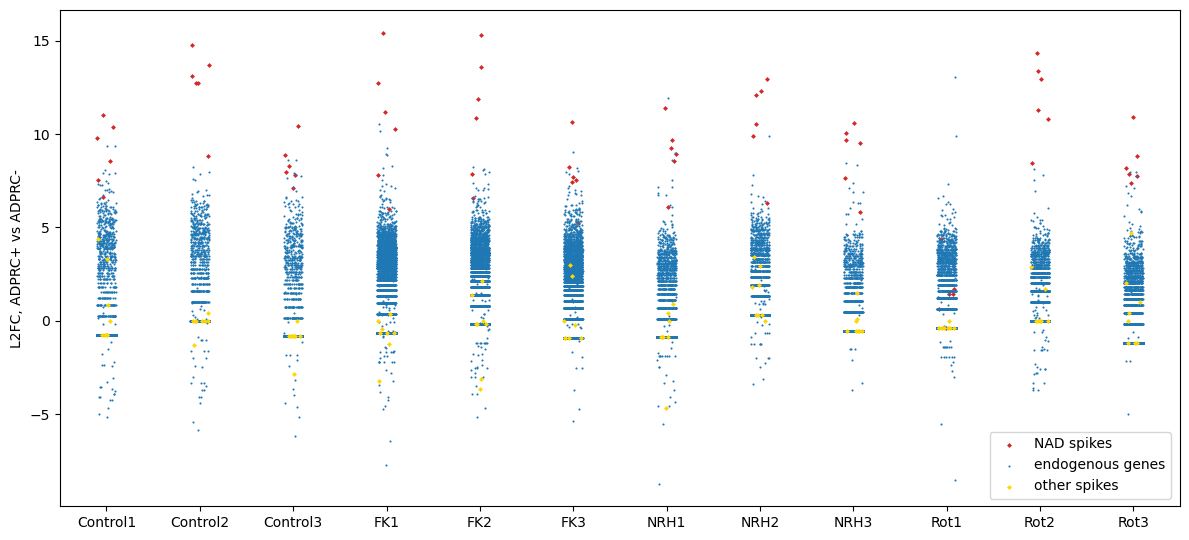

In [13]:
# plotting
df_l2fc_genes = adata.varm["L2FC"].reset_index()\
    .melt(id_vars = "Feature")
df_l2fc_genes["var"] = [char[:-1] for char in df_l2fc_genes["variable"]]

df2 = adata.uns["L2FC_spikes"].reset_index()\
    .melt(id_vars = "Feature")
df2["var"] = [char[:-1] for char in df2["variable"]]
NAD_spikes = ['nad102A', 'nad200',
       'nad351', 'nad36', 'nad501', 'nad60']
df_NADspike = df2[df2["Feature"].isin(NAD_spikes)].copy()
df_nonNADspike = df2[~df2["Feature"].isin(NAD_spikes)].copy()

plt.rcParams["figure.figsize"] = [12, 5.5]
plt.rcParams["figure.autolayout"] = True

ax = sns.stripplot(data = df_NADspike, y = "value", x= "variable", s = 2.5, color = colors[3], label = "NAD spikes", marker = "D")
ax = sns.stripplot(data = df_l2fc_genes, y = "value", x= "variable", s = 1.5, label = "endogenous genes", color = colors[0])
ax = sns.stripplot(data = df_nonNADspike, y = "value", x= "variable", s = 2.5, marker = "D", color = colors[8], label = "other spikes")
ax.set(ylabel = 'L2FC, ADPRC+ vs ADPRC-', xlabel="")
#plt.gca().set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
plt.legend([handles[0],handles[17], handles[26]], [labels[0],labels[17], labels[26]], 
           bbox_to_anchor=(.83, 0.15), borderaxespad=0.)
plt.tight_layout()
plt.savefig("figures/L2FC.png", dpi=300, pad_inches=0)
plt.show()

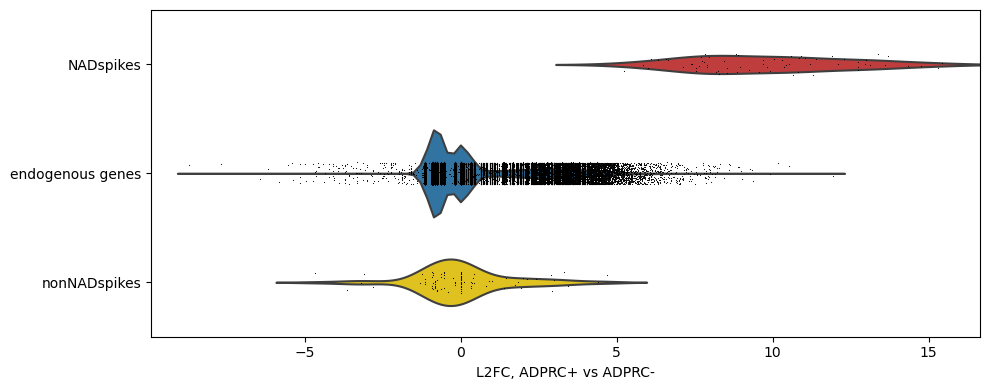

In [14]:
df_NADspike["cat"] = "NADspikes"
df_l2fc_genes["cat"] = "endogenous genes"
df_nonNADspike["cat"] = "nonNADspikes"

# drop Rot1 outlier/ pipetting issue
L2fC_distributions = pd.concat([df_NADspike, df_l2fc_genes, df_nonNADspike])
L2fC_distributions = L2fC_distributions[L2fC_distributions["variable"] != "Rot1"]


fig, ax = plt.subplots(figsize = [10,4])
ax = sns.violinplot(data = L2fC_distributions, x = "value", y = "cat", scale = "area", \
                    inner = None, palette = [colors[3], colors[0], colors[8]])
ax = sns.stripplot(data = L2fC_distributions, x = "value", y = "cat", s = 0.8, c = "black")
ax.set(ylabel = None, xlabel = "L2FC, ADPRC+ vs ADPRC-")
plt.tight_layout()
plt.savefig("figures/Distributions_statTest.png", dpi=300, pad_inches=0)
plt.show()

In [15]:
df_l2fc_genes_grouped = df_l2fc_genes.groupby(["var", "Feature"])["value"].mean().reset_index()
mean_l2fc_dic = {}
for treat in ["Control", "FK", "NRH", "Rot"]:
    mean_l2fc_dic[treat + "_l2fc" + "_mean"] = df_l2fc_genes_grouped[df_l2fc_genes_grouped["var"] == treat]["value"].values
l2fc_means = pd.DataFrame(mean_l2fc_dic, index = df_l2fc_genes_grouped.query("var == 'Control'")["Feature"].values)
l2fc_means.head()

,Control_l2fc_mean,FK_l2fc_mean,NRH_l2fc_mean,Rot_l2fc_mean
ENSG00000000003.16,-0.534649,-0.062693,-0.365176,0.947219
ENSG00000000419.14,-0.534649,1.924617,-0.365176,0.344767
ENSG00000001084.13,-0.534649,2.068079,-0.365176,0.344767
ENSG00000001460.18,1.601815,0.603973,-0.365176,0.011434
ENSG00000001629.10,-0.534649,-0.591014,1.163145,-0.516887


In [16]:
adata.varm["L2FC"] = adata.varm["L2FC"].merge(l2fc_means, left_index = True, right_index = True)
adata.varm["L2FC"]

,Control1,Control2,Control3,FK1,FK2,FK3,NRH1,NRH2,NRH3,Rot1,Rot2,Rot3,Control_l2fc_mean,FK_l2fc_mean,NRH_l2fc_mean,Rot_l2fc_mean
ENSG00000248527.1,-0.76482,4.381675,1.171516,-0.650097,-0.198819,-0.924127,2.810261,0.331713,1.462939,1.203673,-0.003997,-1.165375,1.596124,-0.591014,1.534971,0.011434
ENSG00000291215.1,-0.76482,1.574321,-0.828484,3.519828,3.501621,3.075873,-0.890179,0.331713,-0.537061,-0.381289,-0.003997,-1.165375,-0.006328,3.365774,-0.365176,-0.516887
ENSG00000223764.2,-0.76482,-0.010642,3.258979,-0.650097,-0.198819,-0.924127,-0.890179,0.331713,-0.537061,-0.381289,-0.003997,-1.165375,0.827839,-0.591014,-0.365176,-0.516887
ENSG00000187608.10,-0.76482,-0.010642,-0.828484,-0.650097,-0.198819,-0.924127,-0.890179,0.331713,-0.537061,3.078142,-0.003997,-1.165375,-0.534649,-0.591014,-0.365176,0.636257
ENSG00000078808.20,-0.76482,-0.010642,-0.828484,-0.650097,2.608536,4.433425,-0.890179,0.331713,-0.537061,-0.381289,-0.003997,-1.165375,-0.534649,2.130621,-0.365176,-0.516887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000291389.1,-0.76482,-0.010642,-0.828484,-0.650097,1.386144,-0.924127,-0.890179,1.916675,2.270294,-0.381289,-0.003997,0.834625,-0.534649,-0.062693,1.098930,0.149780
ENSG00000291396.1,-0.76482,-0.010642,2.630948,-0.650097,-0.198819,-0.924127,-0.890179,0.331713,-0.537061,-0.381289,0.996003,-1.165375,0.618495,-0.591014,-0.365176,-0.183554
ENSG00000275748.4,0.23518,-0.010642,-0.828484,-0.650097,-0.198819,2.776312,-0.890179,0.331713,-0.537061,-0.381289,-0.003997,-1.165375,-0.201315,0.642466,-0.365176,-0.516887
ENSG00000276700.1,-0.76482,-0.010642,-0.828484,0.934866,-1.198819,-0.924127,-0.890179,1.331713,2.047902,-0.381289,0.996003,-1.165375,-0.534649,-0.396027,0.829812,-0.183554


In [17]:
# in this dataframe i will put the results of the statistical tests.
# get the mean columns with regular expression
mean_cols = adata.varm["L2FC"].columns[adata.varm["L2FC"].columns.str.match(r'\w*mean')]
adata.varm["L2FC_mean_statTests"] = adata.varm["L2FC"][mean_cols]
adata.varm["L2FC_mean_statTests"].head()

,Control_l2fc_mean,FK_l2fc_mean,NRH_l2fc_mean,Rot_l2fc_mean
ENSG00000248527.1,1.596124,-0.591014,1.534971,0.011434
ENSG00000291215.1,-0.006328,3.365774,-0.365176,-0.516887
ENSG00000223764.2,0.827839,-0.591014,-0.365176,-0.516887
ENSG00000187608.10,-0.534649,-0.591014,-0.365176,0.636257
ENSG00000078808.20,-0.534649,2.130621,-0.365176,-0.516887


In [18]:
nonNADspike_array = df_nonNADspike.query("variable != 'Rot1' and Feature != 'biotinRna'")["value"].values
nonNADspike_array

array([-7.64820146e-01,  8.20142355e-01, -7.64820146e-01, -7.64820146e-01,
       -7.64820146e-01,  4.38492697e+00,  3.32264270e+00, -1.06419589e-02,
       -1.06419589e-02, -1.06419589e-02, -1.06419589e-02, -1.06419589e-02,
       -1.31549654e+00,  4.04395540e-01, -8.28483753e-01, -8.28483753e-01,
       -8.28483753e-01, -8.28483753e-01, -8.28483753e-01, -8.28483753e-01,
       -2.82848375e+00, -6.50096587e-01,  3.49903413e-01, -4.27704166e-01,
       -6.50096587e-01, -6.50096587e-01, -3.20029367e+00, -1.23505909e+00,
       -1.98818749e-01,  2.12310935e+00,  1.38614375e+00, -1.98818749e-01,
       -1.98818749e-01, -3.65825037e+00, -3.10570934e+00, -9.24127383e-01,
       -9.24127383e-01,  2.39780071e+00, -9.24127383e-01, -9.24127383e-01,
       -2.46055478e-01,  2.98276321e+00, -8.90178725e-01,  9.17176197e-01,
       -8.90178725e-01, -8.90178725e-01, -8.90178725e-01, -4.66628271e+00,
        4.31749369e-01,  3.31712566e-01,  2.91667507e+00,  1.91667507e+00,
        3.31712566e-01,  

In [19]:
treatments = ["Control", "FK", "NRH", "Rot"]
def apply_test(test_func, testname, *args, **kwargs):
    pvalue_dic = {}
    
    for treat in treatments:
        # get the columns
        cols = adata.varm["L2FC"].columns[adata.varm["L2FC"].columns.str.match(treat+r'[1-3]')]
        test_population = adata.varm["L2FC"][cols]
        
        pvalues = []
            
        for index, row in test_population.iterrows():            
            # make test 
            test_result = test_func(row, nonNADspike_array, *args, **kwargs)[1]
            pvalues.append(test_result)            
        
        pvalue_dic[treat + "_" + testname + "_" + "pval"] = pvalues
        
    return pvalue_dic

ttest_dict = apply_test(ttest_ind, "ttest", alternative= "greater")
wilcoxon_dict = apply_test(ranksums, "wilcoxon", alternative= "greater")

combined_test_dic = ttest_dict | wilcoxon_dict

In [20]:
adata.varm["L2FC_mean_statTests"] = adata.varm["L2FC_mean_statTests"].merge(
    pd.DataFrame(combined_test_dic, index = adata.var_names),
    left_index = True, right_index = True).sort_index(axis=1)
adata.varm["L2FC_mean_statTests"].head()

,Control_l2fc_mean,Control_ttest_pval,Control_wilcoxon_pval,FK_l2fc_mean,FK_ttest_pval,FK_wilcoxon_pval,NRH_l2fc_mean,NRH_ttest_pval,NRH_wilcoxon_pval,Rot_l2fc_mean,Rot_ttest_pval,Rot_wilcoxon_pval
ENSG00000248527.1,1.596124,0.055994,0.114504,-0.591014,0.730186,0.808859,1.534971,0.058669,0.035093,0.011434,0.495948,0.464686
ENSG00000291215.1,-0.006328,0.503240,0.545365,3.365774,0.000388,0.003241,-0.365176,0.647813,0.624210,-0.516887,0.704105,0.706944
ENSG00000223764.2,0.827839,0.201378,0.247062,-0.591014,0.730186,0.808859,-0.365176,0.647813,0.624210,-0.516887,0.704105,0.706944
ENSG00000187608.10,-0.534649,0.710539,0.736671,-0.591014,0.730186,0.808859,-0.365176,0.647813,0.624210,0.636257,0.260239,0.356733
ENSG00000078808.20,-0.534649,0.710539,0.736671,2.130621,0.017428,0.064322,-0.365176,0.647813,0.624210,-0.516887,0.704105,0.706944


In [21]:
adata.varm["L2FC_mean_statTests"]

,Control_l2fc_mean,Control_ttest_pval,Control_wilcoxon_pval,FK_l2fc_mean,FK_ttest_pval,FK_wilcoxon_pval,NRH_l2fc_mean,NRH_ttest_pval,NRH_wilcoxon_pval,Rot_l2fc_mean,Rot_ttest_pval,Rot_wilcoxon_pval
ENSG00000248527.1,1.596124,0.055994,0.114504,-0.591014,0.730186,0.808859,1.534971,0.058669,0.035093,0.011434,0.495948,0.464686
ENSG00000291215.1,-0.006328,0.503240,0.545365,3.365774,0.000388,0.003241,-0.365176,0.647813,0.624210,-0.516887,0.704105,0.706944
ENSG00000223764.2,0.827839,0.201378,0.247062,-0.591014,0.730186,0.808859,-0.365176,0.647813,0.624210,-0.516887,0.704105,0.706944
ENSG00000187608.10,-0.534649,0.710539,0.736671,-0.591014,0.730186,0.808859,-0.365176,0.647813,0.624210,0.636257,0.260239,0.356733
ENSG00000078808.20,-0.534649,0.710539,0.736671,2.130621,0.017428,0.064322,-0.365176,0.647813,0.624210,-0.516887,0.704105,0.706944
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000291389.1,-0.534649,0.710539,0.736671,-0.062693,0.526367,0.614563,1.098930,0.131912,0.180967,0.149780,0.439044,0.223706
ENSG00000291396.1,0.618495,0.264547,0.271663,-0.591014,0.730186,0.808859,-0.365176,0.647813,0.624210,-0.183554,0.575682,0.590146
ENSG00000275748.4,-0.201315,0.583187,0.489898,0.642466,0.256907,0.275879,-0.365176,0.647813,0.624210,-0.516887,0.704105,0.706944
ENSG00000276700.1,-0.534649,0.710539,0.736671,-0.396027,0.658894,0.815680,0.829812,0.198387,0.219939,-0.183554,0.575682,0.590146


## Adding EdgeR pValues

In [22]:
sum_df = pd.DataFrame(index = adata.var_names)
treatments = ["Control", "FK", "NRH", "Rot"]
for treat in treatments:
    df = pd.read_csv("tmp/" + treat + ".csv", index_col = 0)["PValue"]
    df.name = treat + "_sRfishers_pval"
    sum_df = sum_df.merge(df, how = "left", left_index = True, right_index = True)
    
sum_df.fillna(1, inplace = True)
adata.varm["L2FC_mean_statTests"] = adata.varm["L2FC_mean_statTests"].merge(sum_df, how = "left", 
                                        left_index = True, right_index = True).sort_index(axis = 1).astype(np.float32)


## Comparison of statistical tests

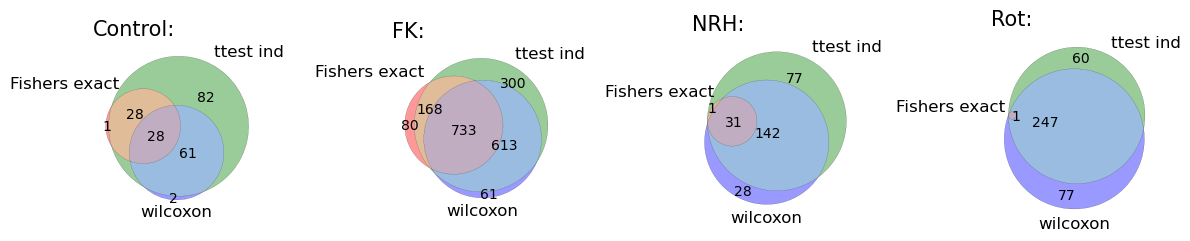

In [23]:
NADcapped_genes ={}
fig, axs = plt.subplots(1,4)
axs = axs.ravel()

df = adata.varm["L2FC_mean_statTests"]
for ax, treat in zip(axs, treatments):
    stat_test_sets = {}
    columns = df.columns
    treat_columns = columns[columns.str.match(treat + r'\w*pval')]
    for test in treat_columns:
        stat_test_sets[test] = set(df[np.logical_and(df[test] < 0.05, df[treat+ "_l2fc_mean"] >= 1) ].index)

    venn3(
        [stat_test_sets[treat + "_sRfishers_pval"], 
           stat_test_sets[treat + "_ttest_pval"], 
           stat_test_sets[treat + "_wilcoxon_pval"]], 
          ('Fishers exact ', 'ttest ind', "wilcoxon"), ax = ax)
    venn3_circles(
        [stat_test_sets[treat + "_sRfishers_pval"], 
           stat_test_sets[treat + "_ttest_pval"], 
           stat_test_sets[treat + "_wilcoxon_pval"]], linewidth = .1,
           ax = ax)
    
    ax.set_title(treat +":", loc = "left", fontsize = 15)

    # save sets
    NADcapped_genes[treat] = stat_test_sets[treat + "_sRfishers_pval"].union(
        stat_test_sets[treat + "_ttest_pval"], 
           stat_test_sets[treat + "_wilcoxon_pval"]
    )
    list_cap_genes = list(NADcapped_genes[treat])
    adata.var["NADcap_" + treat] = adata.var_names.isin(list_cap_genes)

plt.tight_layout()
plt.savefig("figures/Overlap_conditions.png", dpi=300, pad_inches=0)
plt.show()

In [25]:
ctrl_df = adata
#ctrl_df = ctrl_df[:, adata.var["NADcap_Control"] == True]
df = pd.DataFrame(ctrl_df.X.T, index = ctrl_df.var_names, columns = ctrl_df.obs_names)
df = df[["bc03_Control", "bc05_Control", "bc07_Control", "bc04_Control", "bc06_Control", "bc08_Control"]]
df = df.merge(adata.varm["L2FC_mean_statTests"][["Control_sRfishers_pval", "Control_wilcoxon_pval", "Control_ttest_pval"]],
        left_index = True, right_index = True, how = "left")
df.columns = ["C1+", "C2+", "C3+", "C1-", "C2-", "C3-", "Fishers", "wilcoxon", "ttest"]
df= df.astype({"Fishers": np.float32, "ttest": np.float32})

df

,C1+,C2+,C3+,C1-,C2-,C3-,Fishers,wilcoxon,ttest
Feature,,,,,,,,,
ENSG00000248527.1,0,20,3,0,0,0,0.329777,0.114504,0.055994
ENSG00000291215.1,0,2,0,0,0,0,0.178037,0.545365,0.503240
ENSG00000223764.2,0,0,16,0,0,0,0.379885,0.247062,0.201378
ENSG00000187608.10,0,0,0,0,0,0,1.000000,0.736670,0.710539
ENSG00000078808.20,0,0,0,0,0,0,1.000000,0.736670,0.710539
...,...,...,...,...,...,...,...,...,...
ENSG00000291389.1,0,0,0,0,0,0,1.000000,0.736670,0.710539
ENSG00000291396.1,0,0,10,0,0,0,0.592196,0.271663,0.264547
ENSG00000275748.4,1,0,0,0,0,0,0.054437,0.489898,0.583187


In [26]:
examples = ["ENSG00000198712.1", "ENSG00000117519.16", "ENSG00000210082.2", 
            "ENSG00000198695.2", "ENSG00000108854.16", "ENSG00000234705.3",
           "ENSG00000084234.18","ENSG00000183873.18", "ENSG00000027847.14",
           "ENSG00000206585.1", "ENSG00000201185.1", "ENSG00000285776.1"]


def highlighter(x):
    style_lt = "background-color: #EE2E31; color: black; font-weight: bold;"
    style_gt = "background-color: #31D843; color: black; font-weight: bold;"
    gt_mean = x < 0.05
    return [style_gt if i else style_lt for i in gt_mean]

save_df = df.loc[examples, :].style.apply(highlighter, subset = ["Fishers", "ttest", "wilcoxon"])\
    .format("{:.4f}", subset = ["Fishers", "ttest", "wilcoxon"])
save_df.to_latex("figures/test.tex")

In [28]:
# save the data
adata.write("data/anndata.h5ad")
adata

AnnData object with n_obs × n_vars = 24 × 5588
    obs: 'encoding', 'pos_neg', 'treatment', 'gene_counts', 'biotinRna', 'biotin_scalingF'
    var: 'Chr', 'Start', 'End', 'Strand', 'Length', 'Ensemble_ID', 'ensembl_gene_id', 'external_gene_name', 'description', 'gene_biotype', 'entrezgene_id', 'start_position', 'end_position', 'chromosome_name', 'total_values', 'highest_sample', 'NADcap_Control', 'NADcap_FK', 'NADcap_NRH', 'NADcap_Rot', 'sums'
    uns: 'L2FC_spikes', 'enrichmentfactors_spikes', 'normalized_spike_counts', 'original_spike_table', 'spike_correlation', 'spike_counts'
    varm: 'L2FC', 'L2FC_mean_statTests', 'enrichmentfactors'
    layers: 'biotin_scaled'

## Saving information to a spreadsheet

In [29]:
#switch that thing off without deleting
raise(ValueError)

# saving relevant Information to an excel file for Marvin

# reducing tables for proper looking in excel
adata.obsm["spike_counts"].columns.name = ""
adata.obsm["spike_counts"].index.name = ""

# Create a Pandas Excel writer using XlsxWriter as the engine.
with pd.ExcelWriter("data/Helios_scincancer.xlsx") as writer:

    # Write each dataframe to a different worksheet.
    adata.obsm["spike_counts"].to_excel(writer, sheet_name="spike_counts")
    adata.obsm["normalized_spike_counts"].to_excel(writer, sheet_name="spike_counts_norm")

    pd.DataFrame(np.array(adata[:, sig_genes].X.T), 
                 columns = adata.obs_names, 
                 index = adata[:, sig_genes].var_names).to_excel(writer, sheet_name="raw_counts_sig_genes")

    pd.DataFrame(np.array(adata[:, sig_genes].layers["biotin_scaled"].T.round(2)), 
                 columns = adata.obs_names, 
                 index = adata[:, sig_genes].var_names).to_excel(writer, sheet_name="norm_counts_sig_genes")
    
    adata[:,sig_genes].varm["enrichment_factors"].to_excel(writer, sheet_name="enrichmentF_sig_genes")
    
    adata[:,sig_genes].varm["l2fc"].to_excel(writer, sheet_name="l2fc_sig_genes")
    

    adata[:, sig_genes].var.iloc[:,4:].to_excel(writer, sheet_name="annotation_sig_genes")

    pd.DataFrame(np.array(adata[:, ~sig_genes].X.T), 
                 columns = adata.obs_names, 
                 index = adata[:, ~sig_genes].var_names).sample(100).to_excel(writer, sheet_name="counts_random_nonsig_genes")

ValueError: 